In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd

In [20]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [22]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [23]:
# reflect an existing database into a new model
hawaii_weather = automap_base()

# reflect the tables
hawaii_weather.prepare(engine, reflect = True)

In [24]:
# We can view all of the classes that automap found
print (hawaii_weather.classes.keys())

['measurement', 'station']


In [25]:
# Save references to each table
measurement = hawaii_weather.classes.measurement
station = hawaii_weather.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

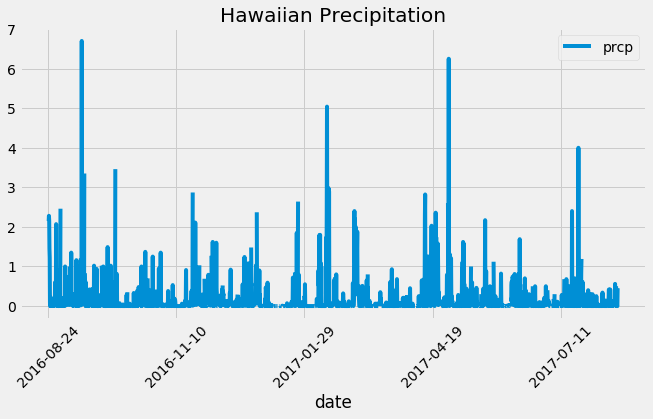

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(func.max(measurement.date)).first()[0]
last_date = dt.datetime.strptime(last_date,'%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
prev_year = last_date - dt.timedelta(365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date,measurement.prcp).filter(measurement.date>=prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
hawaii_df = pd.DataFrame(results).set_index("date")

# Sort the dataframe by date
hawaii_df = hawaii_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
hawaii_df.plot(rot = 45, figsize = (10,5))
plt.title("Hawaiian Precipitation")
plt.savefig("Precipitation.png") 
plt.show()


In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
hawaii_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [44]:
# Design a query to show how many stations are available in this dataset?
hi_stations = session.query(station).count()
hi_stations

9

In [49]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_station = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
select = [func.min(measurement.tobs),
         func.max(measurement.tobs),
         func.avg(measurement.tobs)]

select_query = session.query(*select).filter(measurement.station == "USC00519281").all()
select_query

[(54.0, 85.0, 71.66378066378067)]

In [61]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement.tobs).filter(measurement.date >=prev_year).\
            filter(measurement.station == "USC00519281").\
            order_by(measurement.date).all()
temp_df = pd.DataFrame(temp_data, columns=["TOBS"])

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
